# DSMCER Notebook 7 - Resampling

1. Bootstrapping
    1. Bootstrapping of SML model variance
    2. Bootstrapping to reduce variance ("bagging")
2. Validation
    1. Validation dataset for optimization
    2. _Exercise_: Find the best K
    3. K-fold cross validation
    4. _Poll_: What should K be?
    5. Leave-one-out
    6. _Exercise_: cost of validation

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.linear_model
import sklearn.neighbors

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

# ! NEW
import sklearn.ensemble
import time

import warnings
warnings.filterwarnings("ignore")

***
***

<font size=5><center> __We discussed bootstrapping__ where we can create an empirical distribution of any statistic to estimate the population.

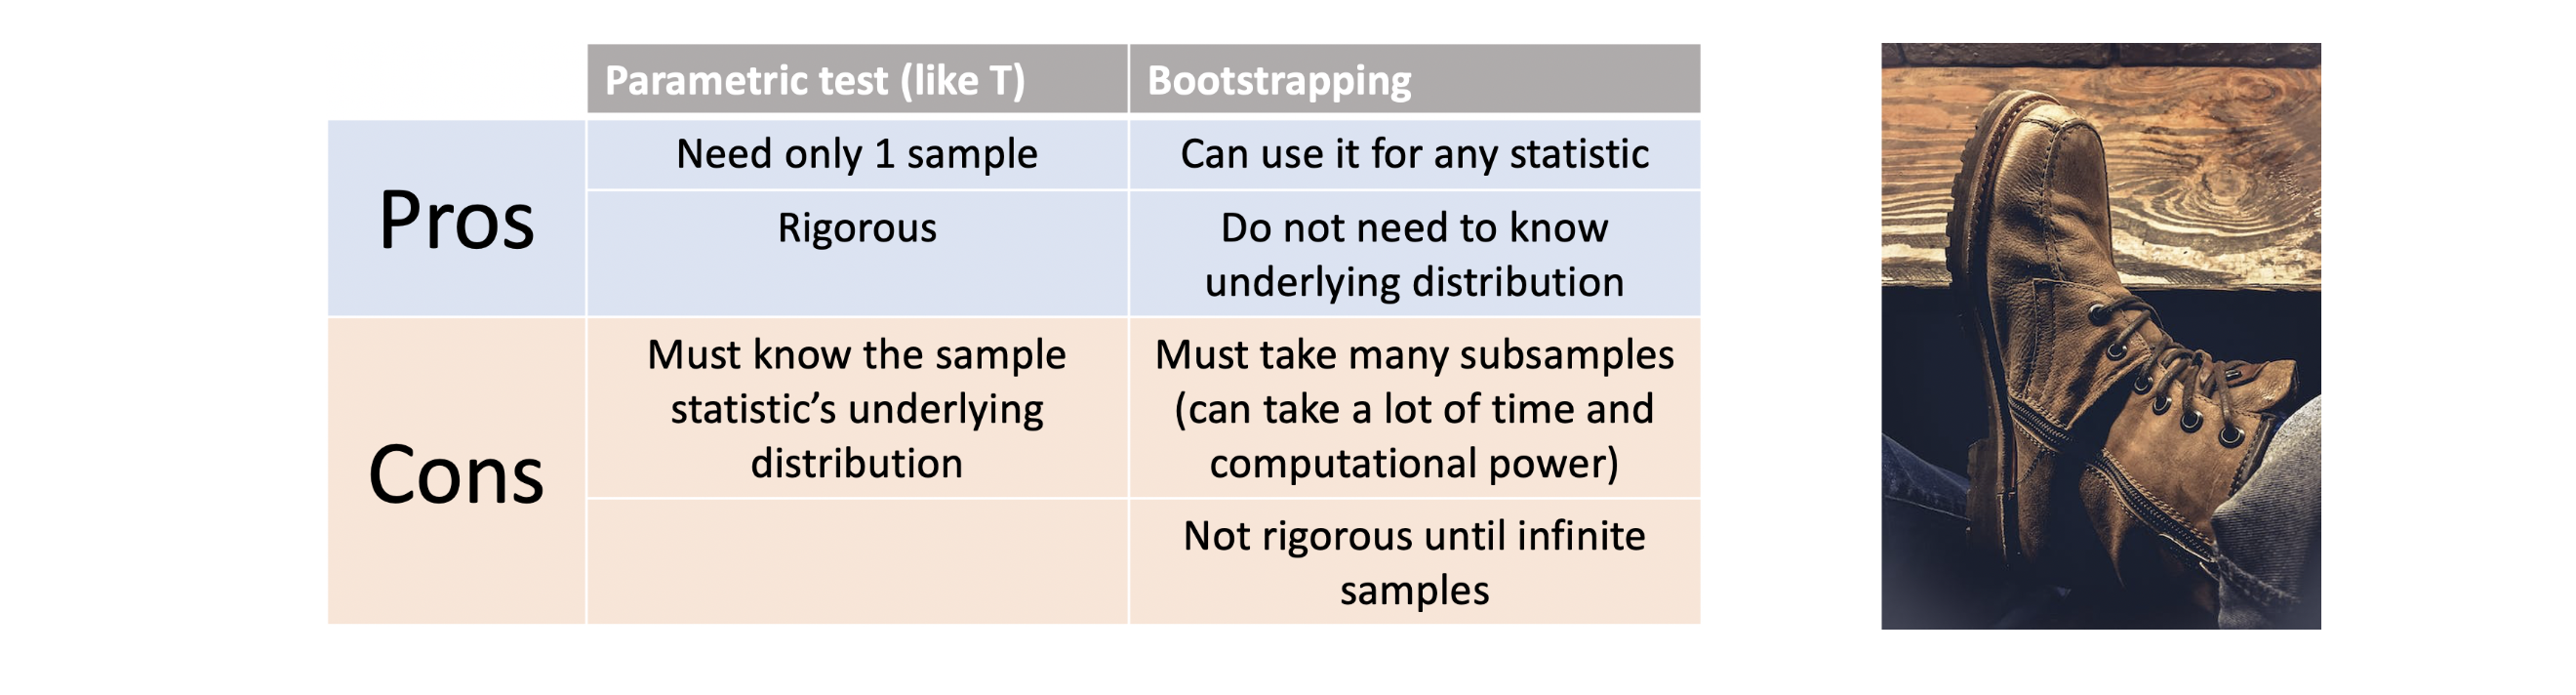

***

<font size=5><center> We have also conducted some supervised machine learning, where we take data that we have and use it to make an estimator of a desired function. __We craft a test set to estimate the generalizability of out model.__

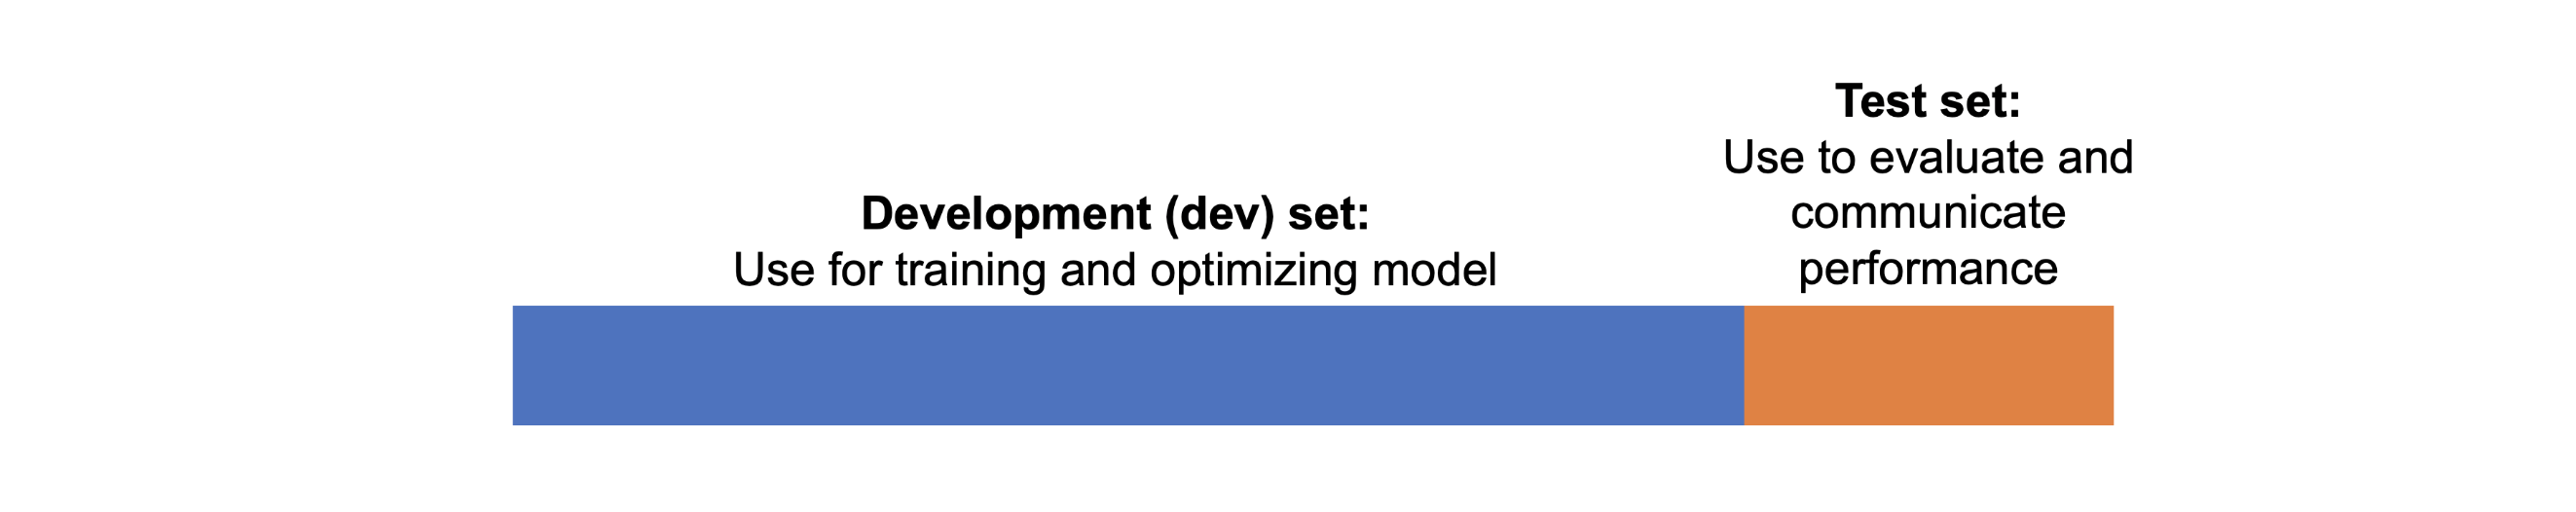

In [2]:
# load the data by downloading it
df = pd.read_csv('HCEPDB_moldata.zip').sample(500, random_state=200) # small dataset to make this easier to handle

FileNotFoundError: [Errno 2] No such file or directory: 'HCEPDB_moldata.zip'

In [ ]:
data = df[['jsc', 'e_lumo_alpha']]

In [ ]:
dev, test = sklearn.model_selection.train_test_split(data, test_size=0.15, random_state=1)

<font size=5><center> We discussed the __bias variance tradeoff__, and we sampled our data in different ways to probe the variance:

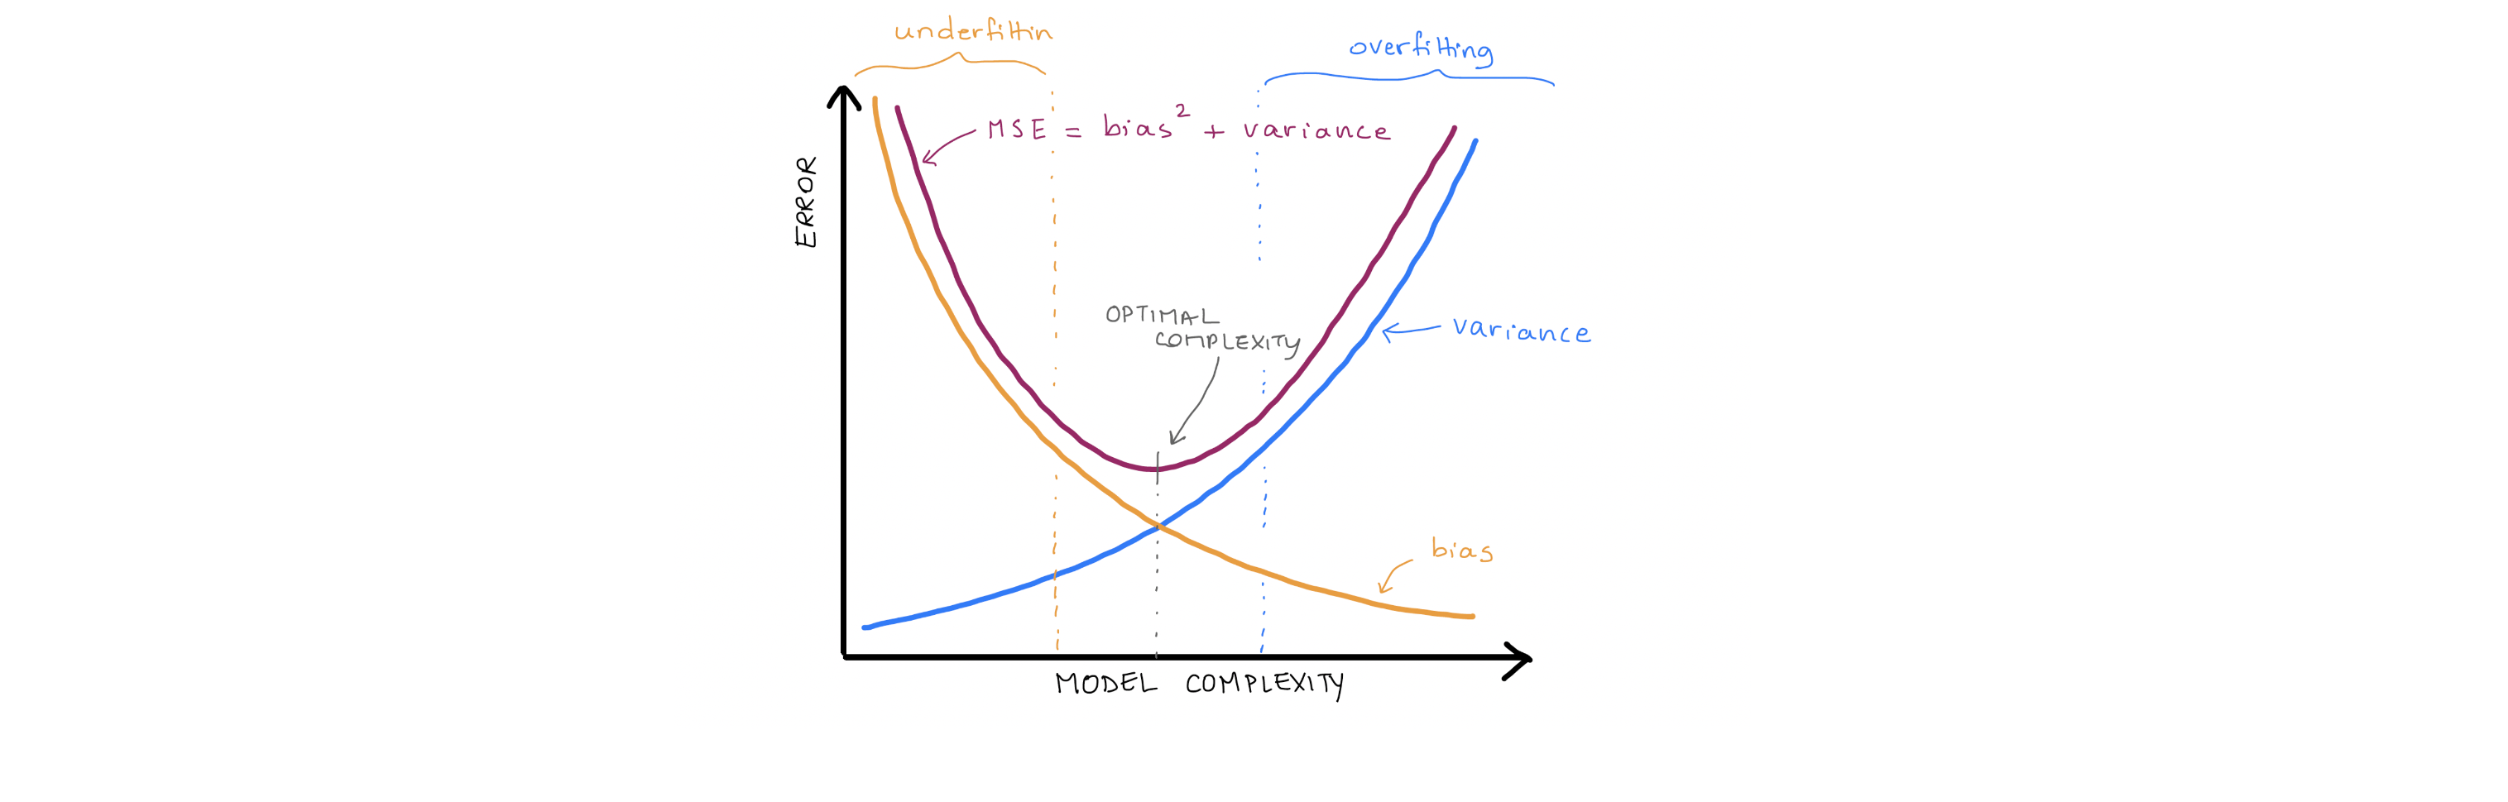

<font size=5><center> In each of the above tasks, we took samples of our dataset. __It is worth rigourously discussing the differences between these__.

***

## 1. Bootstrapping

<font size=4>Bootstrapping is defined by the following characteristics:
    
<font size=4> - We take a large number of samples
    
<font size=4> - We sample with replacement
    
<font size=4> - Each sample size is the original dataset size
    
<font size=5><center> __We do this with the specific goal of estimating the population of any statistic!__

***

### A. Bootstrapping of SML model variance

<font size=4>In the context of SML -  we might use bootstrapping to rigorously estimate the variance of model parameters:

In [ ]:
def regression_weight(X_sample, y_sample):
    model = sklearn.linear_model.LinearRegression()
    model.fit(X_sample.reshape(-1,1), y_sample.reshape(-1,1))
    return model.coef_[0][0]

In [ ]:
weights = []
for i in range(1000):
    sample = dev.sample(n=len(dev), replace=True)
    
    weights.append(regression_weight(sample['jsc'].values, sample['e_lumo_alpha'].values))

In [ ]:
sns.histplot(weights)

<font size=4>Linear regression has very low variance.

***

### B. Bootstrapping to reduce variance ("bagging")

<font size=5><center> Recall that variance describes the model __variability from the population model due to data__:

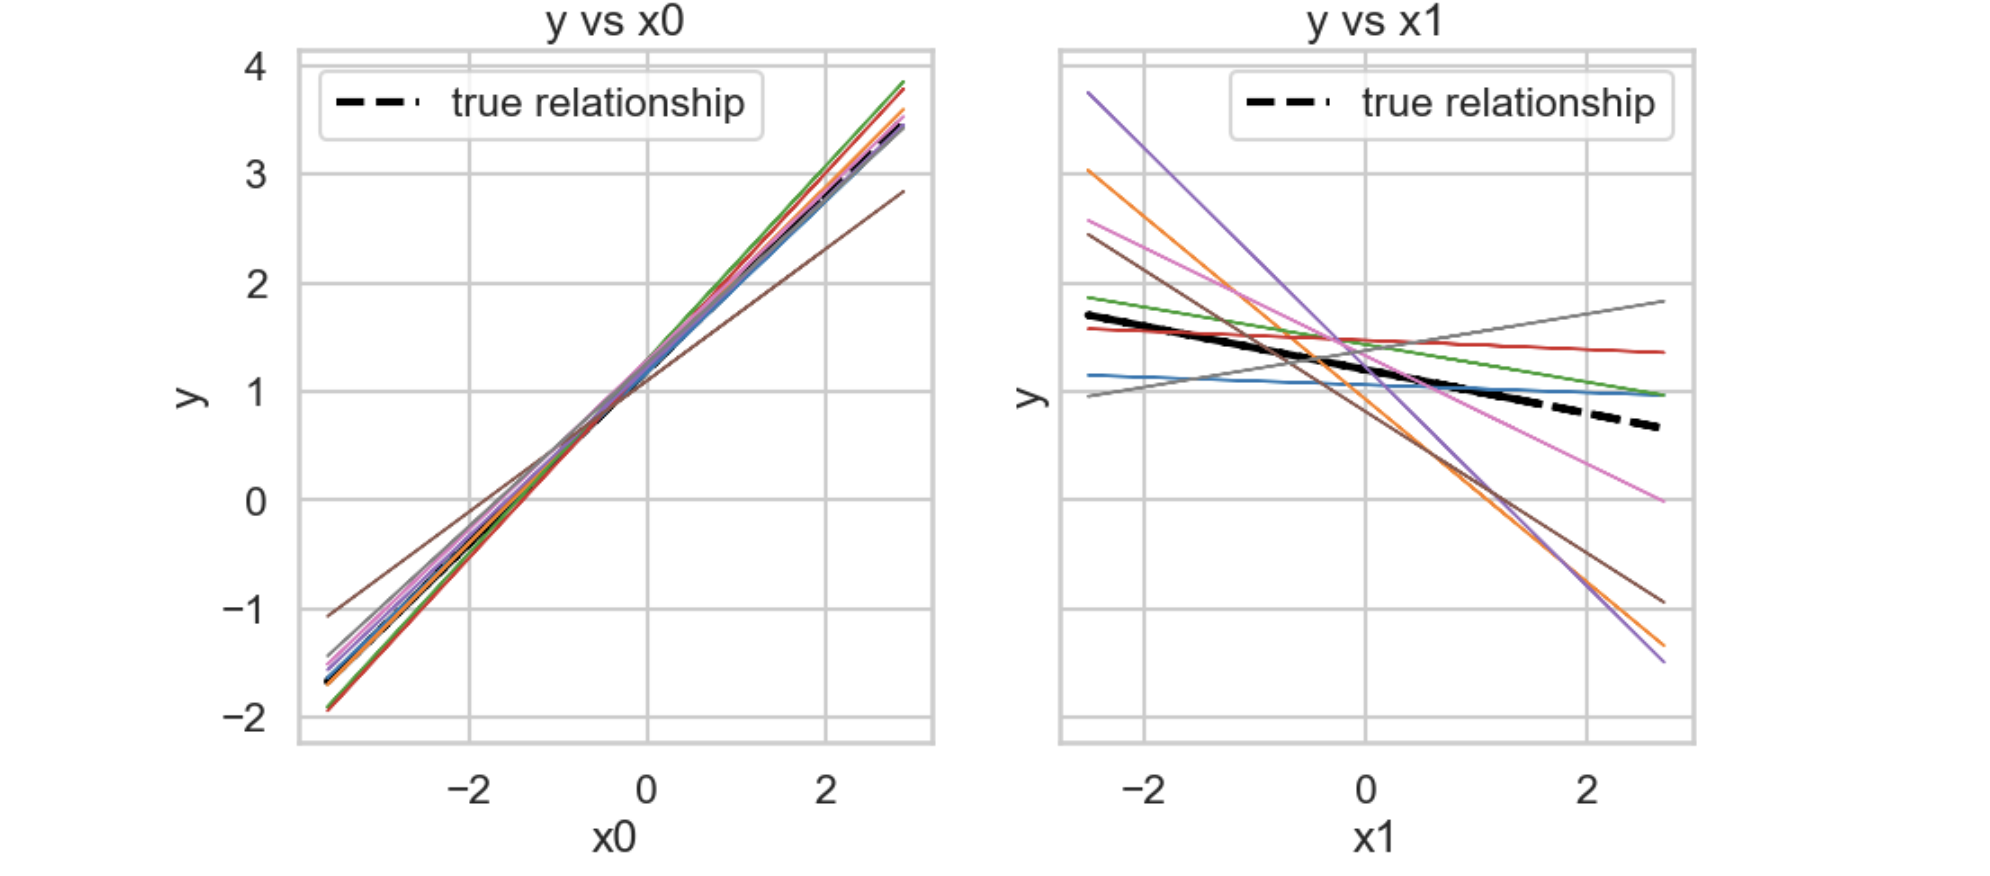

***

<font size=5><center> __We can average over different sample models to reduce variance.__ This process is called "bagging" and results in an __ensemble__ of models each trained on different datasets:
    
<font size=4>__NOTE__: Ensemble just means many models working together. Bagging models is just one type of ensemble.

<font size=4> *For training*
    
<font size=4> 1.  Randomly sample the training data N times (bootstrap)
    
<font size=4> 2. Train N models on the samples, the resulting N models is the ensemble model
    
<font size=4> *For prediction*
    
<font size=4> 1. Predict target with each of the N models
    
<font size=4> 2. Average over N predictions to create ensemble prediction

In [ ]:
knn_no_bagging = sklearn.neighbors.KNeighborsRegressor(n_neighbors=2)
knn_no_bagging.fit(dev['jsc'].values.reshape(-1,1), dev['e_lumo_alpha'])
print('Test MSE of KNN trained on dev data',
      sklearn.metrics.mean_squared_error(test['e_lumo_alpha'], knn_no_bagging.predict(test['jsc'].values.reshape(-1,1))))

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(test, x='jsc', y='e_lumo_alpha', ax=ax)

x = np.linspace(*ax.get_xlim()).reshape(-1,1)
ax.plot(x, knn_no_bagging.predict(x), label='KNN without bagging', c='tab:orange')
ax.set_title('Test predictions')
ax.legend()

<font size=4>`sklearn` has a class that allows us to quickly do bagging:

In [ ]:
base_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=2)
knn_bagging = sklearn.ensemble.BaggingRegressor(base_model, n_estimators=1000, random_state=1) # bootstrap the data 1000 times 

# train and test
knn_bagging.fit(dev['jsc'].values.reshape(-1,1), dev['e_lumo_alpha'])
print('Test MSE of KNN trained in bags',
      sklearn.metrics.mean_squared_error(test['e_lumo_alpha'], knn_bagging.predict(test['jsc'].values.reshape(-1,1))))

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(test, x='jsc', y='e_lumo_alpha', ax=ax)

x = np.linspace(*ax.get_xlim()).reshape(-1,1)
ax.plot(x, knn_no_bagging.predict(x), label='KNN without bagging', c='tab:orange')
ax.plot(x, knn_bagging.predict(x), label='KNN with bagging', c='tab:green')
ax.set_title('Test predictions')
ax.legend()

<font size=5><center> We can see that this is a form of regularization - __it tamps down the overfitting__ (reduces base model variance).

***

### C. _Poll_: Other types of ensembles?

<font size=4>Bagging creates an ensemble of models of the __same type trained on different data__ in order to reduce variance. Can you think of other types of ways we could combine models in order to create ensembles? Feel free to google if you are having trouble coming up with something.

***

## 2. Validation

### A. Validation dataset for optimization

<font size=4>Thusfar __we have trained a model with some set of hyperparameters on the dev set, and evaluated its performance on the test set__. Let's close the loop:

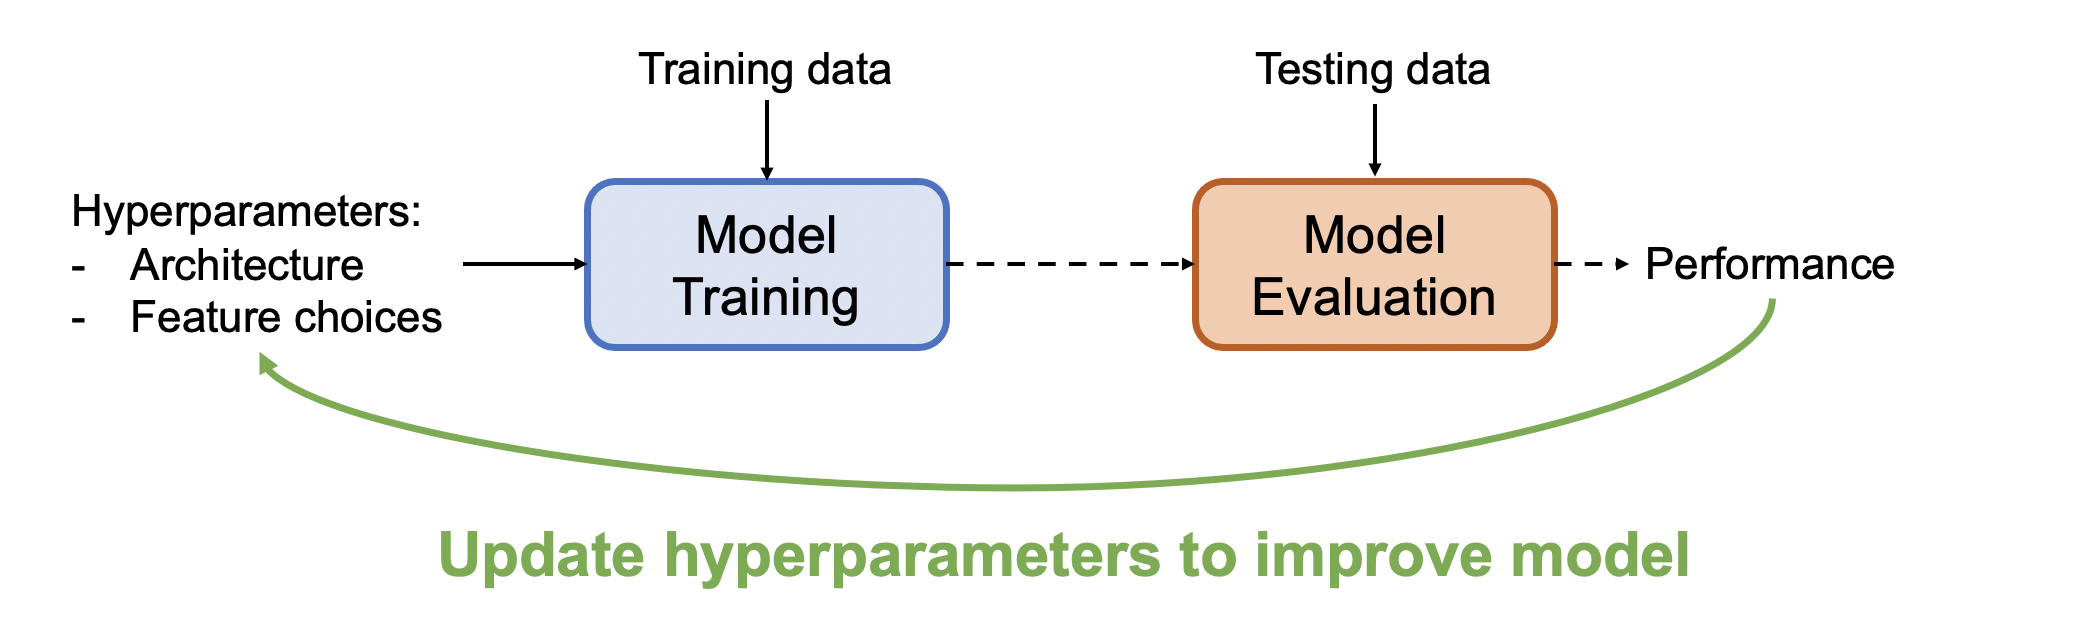

<font size=5><center> __Without modification this violates Rule 0 of SML!__ We need to introduce a set of data for __validation__:

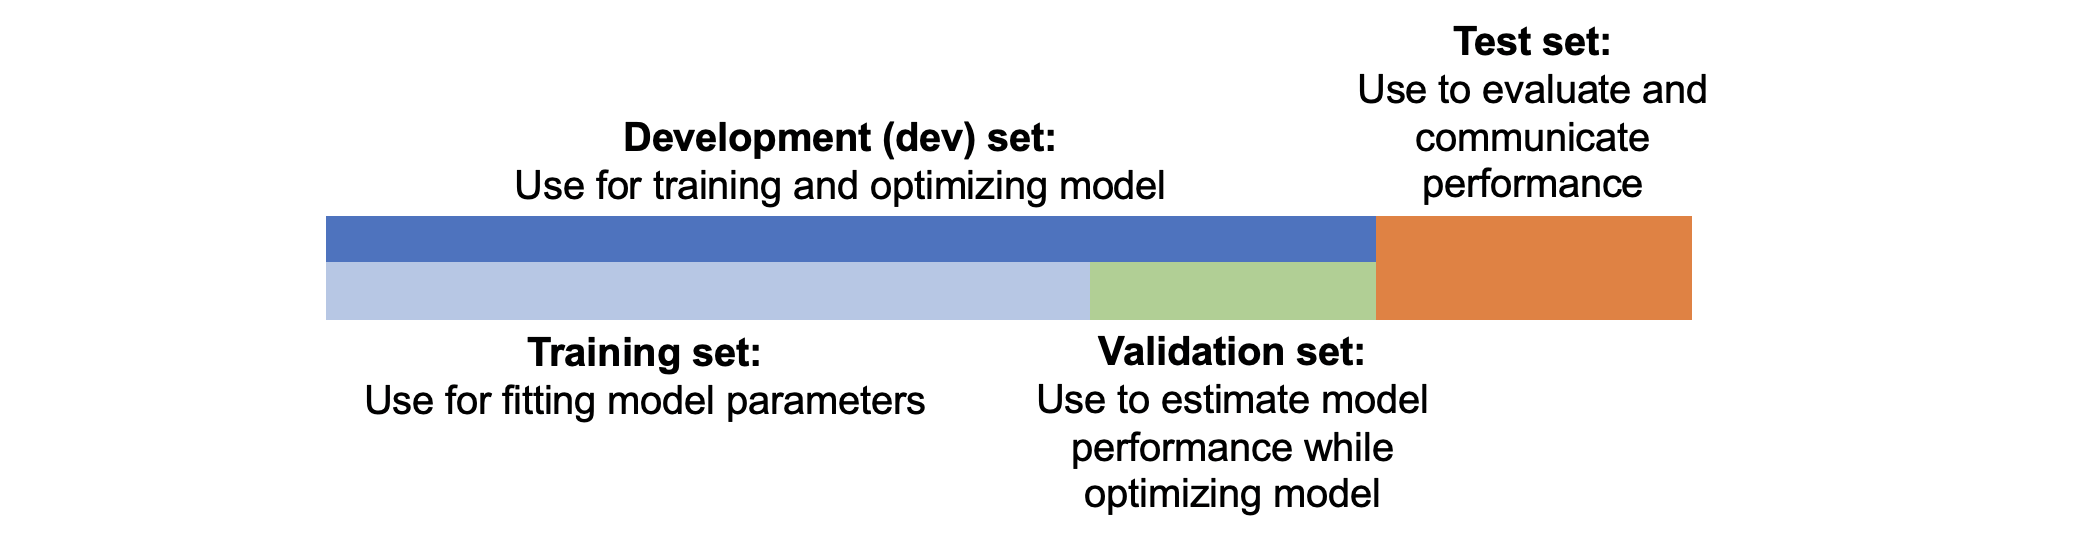

<font size=5><center> This allows us to update model hyperparameters without getting the test set involved:

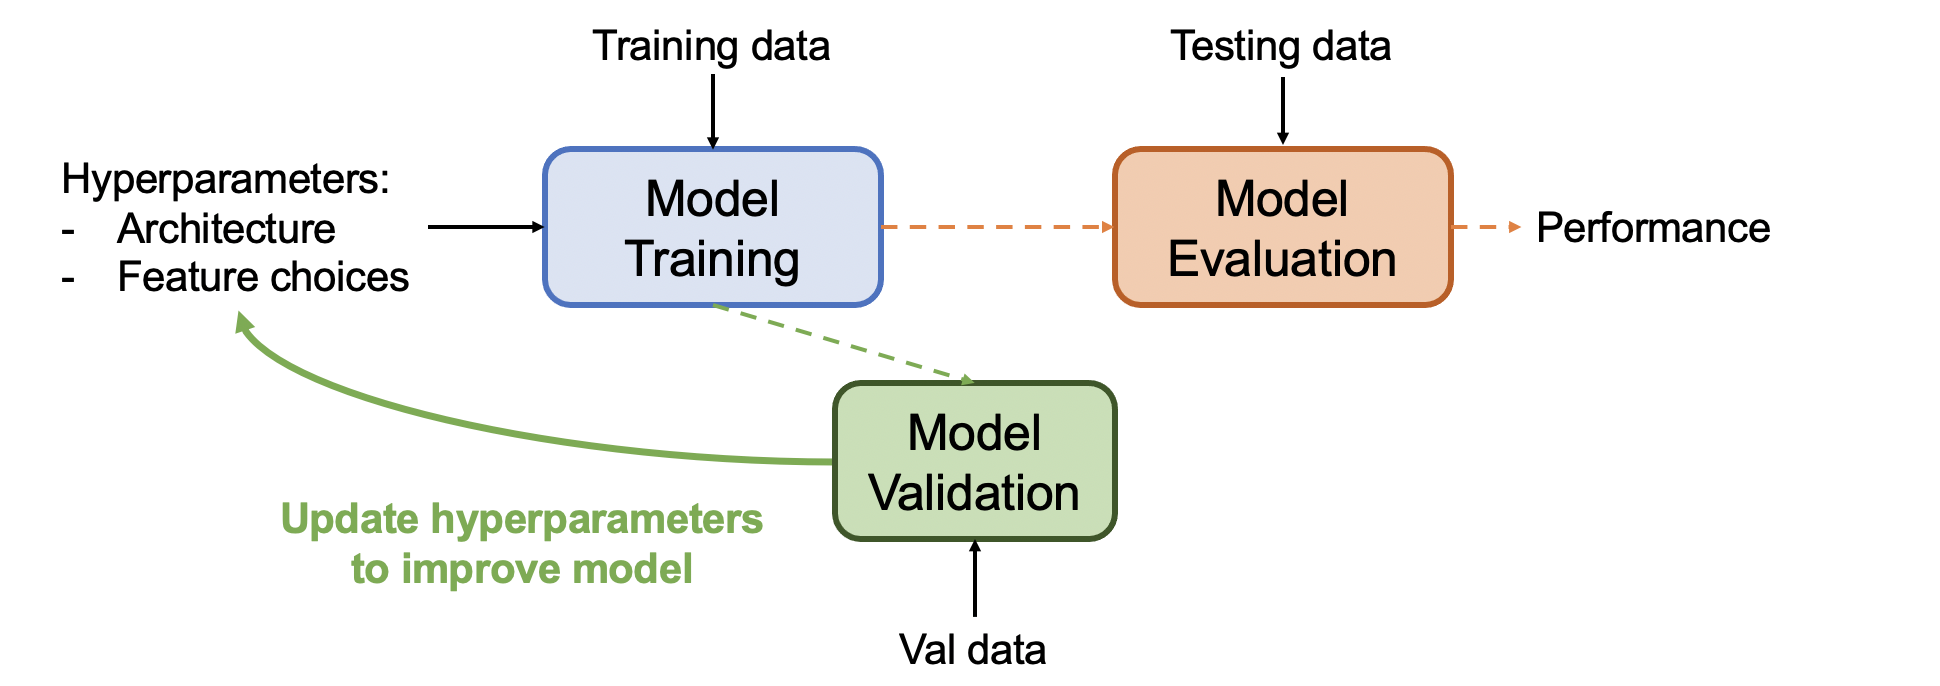

***

In [ ]:
train, val = sklearn.model_selection.train_test_split(dev, test_size=0.15, random_state=1)

### B. _Exercise_: Find the best K

<font size=4>__Train KNN regressor to predict E LUMO from JSC and evaluate its performance on the validation set__. Repeat this for multiple values of K and __pick the best value of the hyperparameter in order to train and test a final model.__

> <span style='color:red'>remove for lecture

In [15]:
val_mses = []
ks = list(range(1,50))

for k in ks:
    knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(train['jsc'].values.reshape(-1,1), train['e_lumo_alpha'])
    val_mses.append(
        sklearn.metrics.mean_squared_error(val['e_lumo_alpha'], knn.predict(val['jsc'].values.reshape(-1,1))))

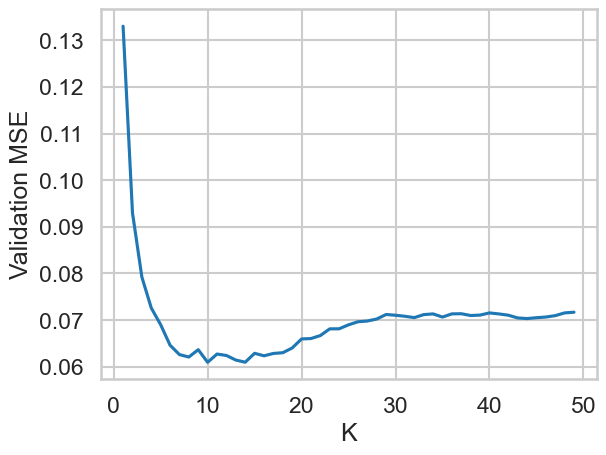

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel('K')
ax.set_ylabel('Validation MSE')
ax.plot(ks, val_mses)

In [17]:
best_k = ks[np.argmin(val_mses)]
print(f'Best value of K is {best_k}')

Best value of K is 10


In [18]:
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=best_k)
knn.fit(dev['jsc'].values.reshape(-1,1), dev['e_lumo_alpha'])
print('Test MSE', sklearn.metrics.mean_squared_error(test['e_lumo_alpha'], knn.predict(test['jsc'].values.reshape(-1,1))))

Test MSE 0.06095981187267057


<font size=4>Once the best value of the hyperparameter is chosen, we can use all of the dev data to train. We do not want to waste data.

***

### C. K-fold Cross Validation

<font size=5><center> Given what we know about samples vs population, it is possible that our single validation set is biased and not a good estimate of population performance. Let's validate multiple times and average:

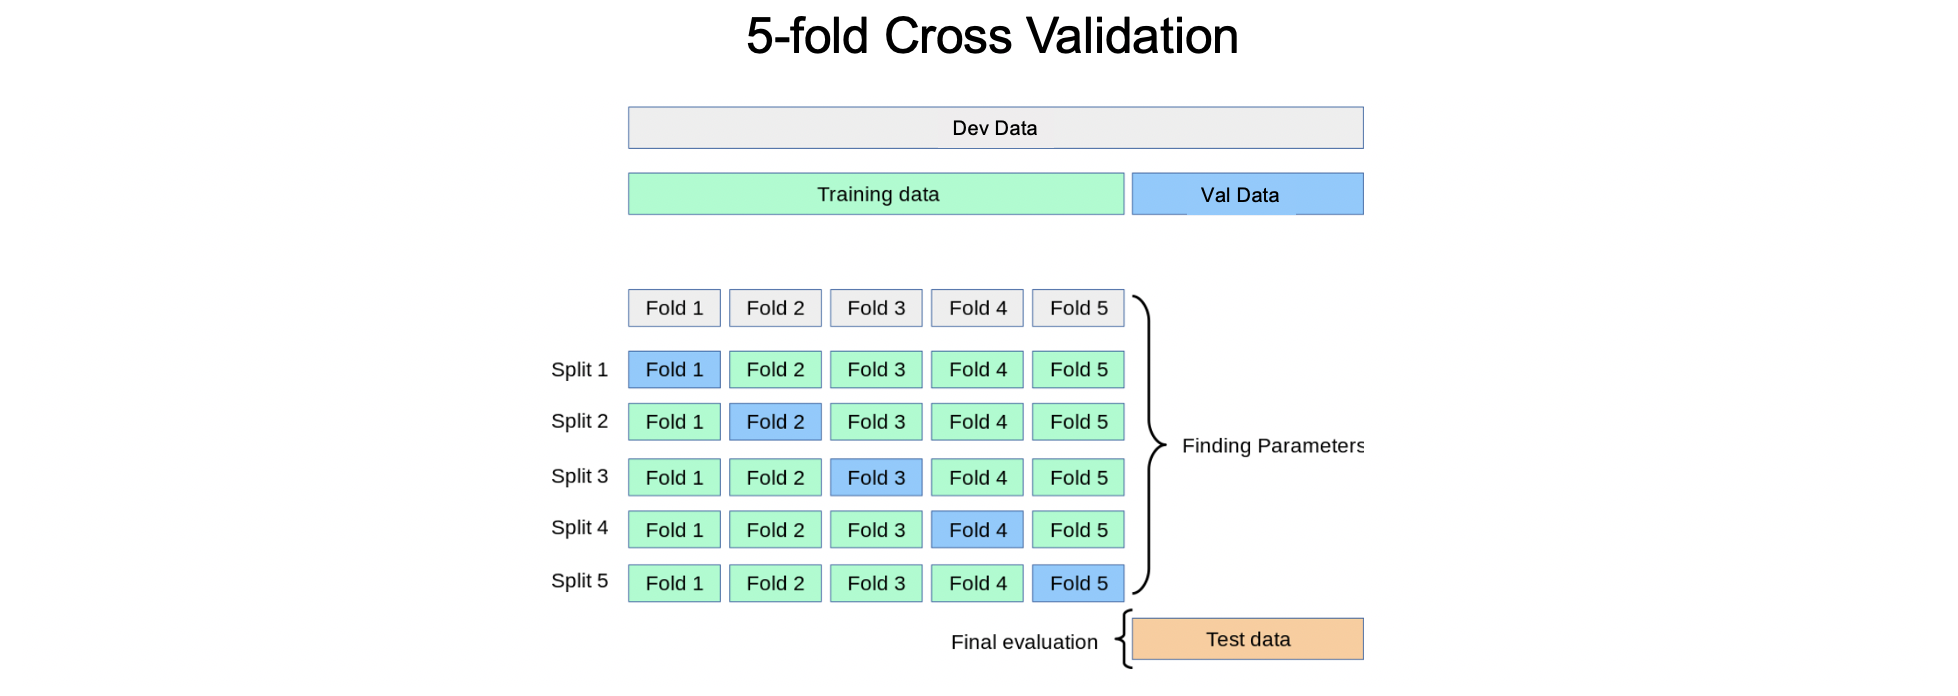

<font size=4> - __Step one__: split the dev set into K "folds". No data is shared between folds.

<font size=4> - __Step two__: For each fold, treat it as a validation set. Combine the remaining folds as a training set. Train and evaluate
    
<font size=4> - __Step three__: Average validation performance over each of K models/folds
    
<font size=4> `sklearn` has a class that does the splitting for us:

In [19]:
folds = sklearn.model_selection.KFold(n_splits=5).split(dev)

In [20]:
fold_mses = []
for train_indexes, val_indexes in folds: # the KFold splitter returns the indexes of the data, not the data itself
    train = dev.iloc[train_indexes]
    val = dev.iloc[val_indexes]
    
    knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5)
    knn.fit(train['jsc'].values.reshape(-1,1), train['e_lumo_alpha'])
    fold_mses.append(
        sklearn.metrics.mean_squared_error(val['e_lumo_alpha'], knn.predict(val['jsc'].values.reshape(-1,1))))

In [21]:
print(f"5 fold cross validated MSE for 5-Nearest neigbor model (mean, std): ({np.mean(fold_mses)}, {np.std(fold_mses)})")

5 fold cross validated MSE for 5-Nearest neigbor model (mean, std): (0.08236652221403815, 0.010407005380152047)


<font size=5><center> We can see there is variability in the performance. __It is possible with only one validation set that the performance would be singificantly lower than the average__, e.g. .090. K-fold val helps us be more confident in performance.

### D. Leave-One Out

<font size=4> We can take this one step further and have a number of folds equal to the number of datapoints in the dev set. __This removes the posibiblity that our validation performance is biased due to sampling__:

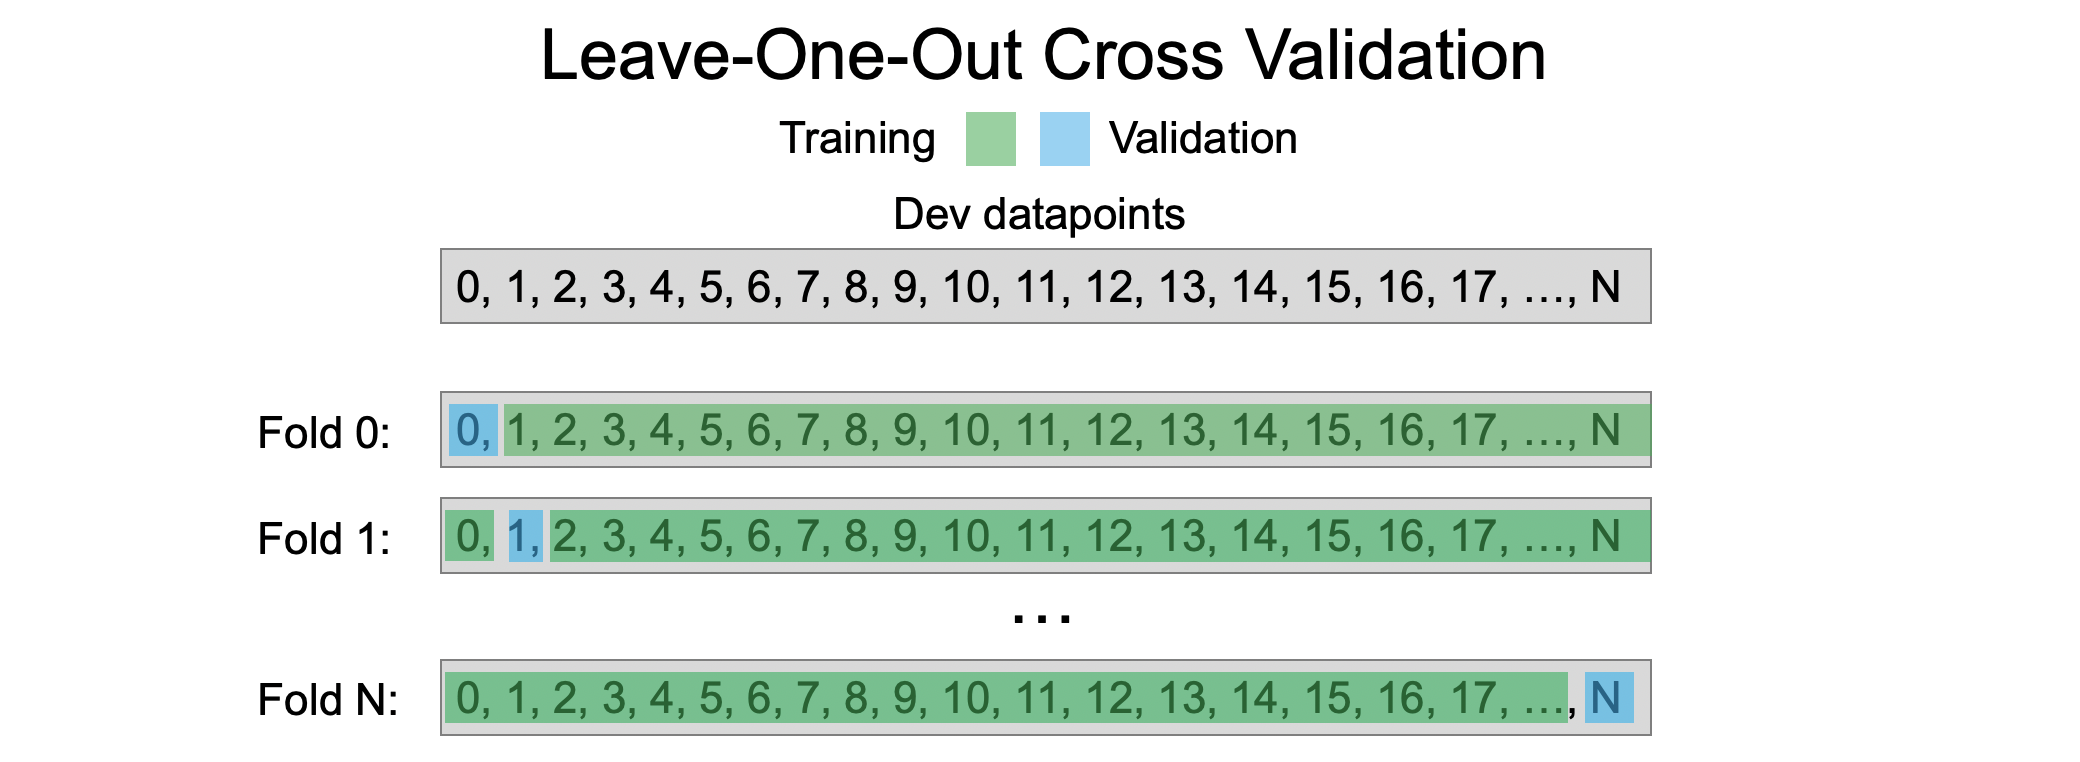

***

In [22]:
folds = sklearn.model_selection.LeaveOneOut().split(dev)

In [23]:
fold_mses = []
for train_indexes, val_indexes in folds: # the KFold splitter returns the indexes of the data, not the data itself
    train = dev.iloc[train_indexes]
    val = dev.iloc[val_indexes]
    
    knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5)
    knn.fit(train['jsc'].values.reshape(-1,1), train['e_lumo_alpha'])
    fold_mses.append(
        sklearn.metrics.mean_squared_error(val['e_lumo_alpha'], knn.predict(val['jsc'].values.reshape(-1,1))))

In [24]:
print(f"Leave-one-out cross validated MSE for 5-Nearest neigbor model (mean, std): ({np.mean(fold_mses)}, {np.std(fold_mses)})")

Leave-one-out cross validated MSE for 5-Nearest neigbor model (mean, std): (0.0852676448715555, 0.12982362930033728)


<font size=5><center> The interval of the squared error after LOOCV is __much larger than K-fold and is more informative.__

<font size=4>We have an ubiased mean error that we can use for decision making, but we also have a more finegrained intuition of the error that we may incur on a *single* data point. See the STD - __clearly the model can be very off some times.__

<AxesSubplot: ylabel='Count'>

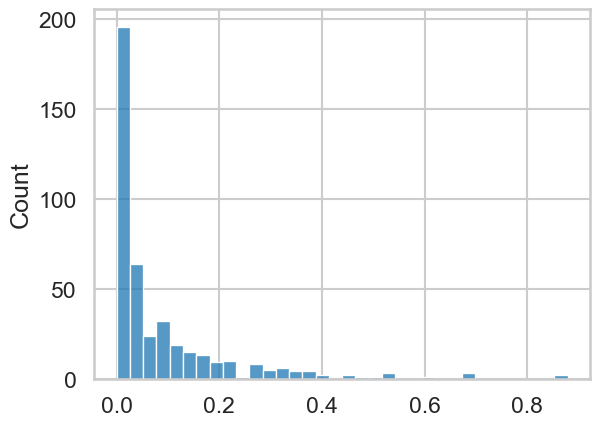

In [25]:
sns.histplot(fold_mses)

<font size=4>We may be off by as much as 0.9 units of E LUMO when predicting.

***

### F. _Exercise_: cost of validation

<font size=4>Leave one out is more informative/statistically sound than e.g. 5 fold CV, which is further better than single validation, but it does not come for free.

In [26]:
# get a larger dataset for this exercise
df = pd.read_csv('HCEPDB_moldata.zip').sample(10000, random_state=200) # small dataset to make this easier to handle

In [27]:
data = df[['jsc', 'e_lumo_alpha']]

In [28]:
dev, test = sklearn.model_selection.train_test_split(data, test_size=0.15, random_state=1)

<font size=4>Using this dev dataset, __run K-Fold CV using K = 2 (single validation set), 5, 10, 100, 1000, and N (Leave one out) to evaluate a KNN regressor__ model for the target E LUMO using the feature JSC. __For each, track the execution time and plot it vs K.__

<font size=4>Note that you can determine execution time of code using `time.time()`, for example:

In [29]:
time0 = time.time()
print('I am going to run something!')
time.sleep(5) # just waits 5 seconds
time1 = time.time()
print(f"It took me {time1-time0} seconds to run the thing.")

I am going to run something!
It took me 5.003797769546509 seconds to run the thing.


> <span style='color:red'>remove for lecture

In [30]:
def do_one_K_fold_val(K=1):
    time1 = time.time()
    folds = sklearn.model_selection.KFold(n_splits=K).split(dev)

    fold_mses = []
    for train_indexes, val_indexes in folds:
        train = dev.iloc[train_indexes]
        val = dev.iloc[val_indexes]

        knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5)
        knn.fit(train['jsc'].values.reshape(-1,1), train['e_lumo_alpha'])
        fold_mses.append(
            sklearn.metrics.mean_squared_error(val['e_lumo_alpha'], knn.predict(val['jsc'].values.reshape(-1,1))))
    
    time2 = time.time()
    execution_time = time2-time1
    print(f"Ran {K} fold CV and got validation MSE mean = {np.mean(fold_mses)}, took {execution_time} seconds")
    return execution_time

In [31]:
Ks = [2, 5, 10, 100, 1000, len(dev)]
times = []
for K in Ks:
    times.append(do_one_K_fold_val(K))

Ran 2 fold CV and got validation MSE mean = 0.07981129096557246, took 0.03941607475280762 seconds
Ran 5 fold CV and got validation MSE mean = 0.07961602742500698, took 0.029274940490722656 seconds
Ran 10 fold CV and got validation MSE mean = 0.07882551257970241, took 0.033019065856933594 seconds
Ran 100 fold CV and got validation MSE mean = 0.0786860760387572, took 0.24529314041137695 seconds
Ran 1000 fold CV and got validation MSE mean = 0.07873584773998119, took 2.299525737762451 seconds
Ran 8500 fold CV and got validation MSE mean = 0.07856538825849563, took 19.47398090362549 seconds


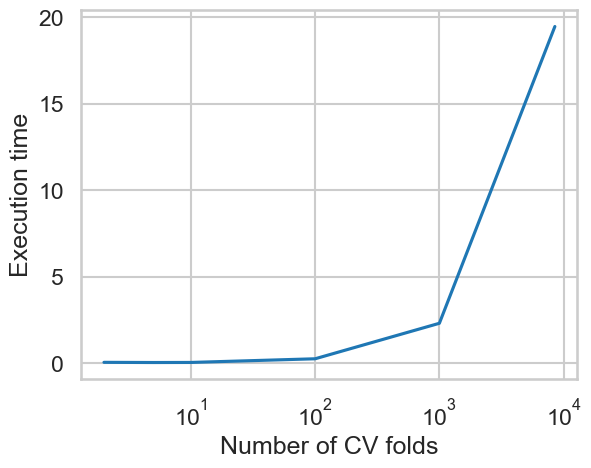

In [32]:
fig, ax = plt.subplots()

ax.set_xlabel('Number of CV folds')
ax.set_ylabel('Execution time')
ax.set_xscale('log')
ax.plot(Ks, times)

### E. _Poll_: what should K be?

<font size=4> By using K fold validation sets and averaging over the evaluations, we increase the significance of our evaluation compared to using a single validation. When it comes to chosing K, which do you agree with?
    
<font size=4> - K __should be large__ because it increase the statistical significance.

<font size=4> - K should __not be small__ because the smaller K, the less training data each model sees
    
<font size=4> - K __should be small__ because the larger K is, the more models we must train, and the more training data is used, which increases the cost of validation.

***



| Validation Type | Cost | Rigor of assessment | When to use |
| --------------- | ---- | ------------------- | ----------- |
| No validation | NA | NA | You are not optimizing model hyperparameters at all, just creating a model and reporting its performance. |
| Single Validation | Low | Low | Dataset is __prohibitively large__, rarely a good choice |
| K fold CV | Medium to high | Medium to High | Usually the method of choice when dataset is not very small |
| Leave one out | Maximum | Maximum | Dataset is very small, model is very cheap to train, or very rigorous evaluation needed |

***

## Summary

<font size=4> - We discussed __bootsrapping - sampling many times with replacement__, which we use to estimate sample statistics of a population, or as a form of regularization but creating "Bagging" Ensembles
    
<font size=4> - We discussed splitting the dev dataset into __test and validation without replacement__, which we can use to __estimate test set performance and optimize model hyperparameters__.
    
<font size=4> - We discussed __multiple ways to conduct validation__, with increasing statistical significance but also increasing cost.

## A challenge for you...

<font size=4> Cross validate a bootstraped 95% confidence interval on average nearest-neighbor distance of the validation data